In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from matplotlib import pyplot as plt
from nilearn import datasets, plotting, image, maskers
from torch import load, device
from nilearn.plotting import plot_roi, plot_stat_map

In [2]:
#Atlas
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
yeo = atlas_yeo_2011.thick_7
mist = '/home/maelle/DataBase/fMRI_parcellations/MIST_parcellation/Parcellations/MIST_ROI.nii.gz'

In [3]:
import numpy as np
from nilearn import datasets, plotting, image, maskers

atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
yeo = atlas_yeo_2011.thick_7
mist = '/home/maelle/DataBase/fMRI_parcellations/MIST_parcellation/Parcellations/MIST_ROI.nii.gz'

masker = maskers.NiftiMasker(standardize=False, detrend=False)
masker.fit(mist)
mist_vec = masker.transform(mist)

np.unique(mist_vec)
yeo_vec = masker.transform(yeo)
yeo_vec = np.round(yeo_vec)
np.unique(yeo_vec)
matches = []
match = []
best_overlap = []
for i, roi in enumerate(np.unique(mist_vec)):
    overlap = []
    for roi2 in np.unique(yeo_vec):
        overlap.append(np.sum(yeo_vec[mist_vec == roi] == roi2) / np.sum(mist_vec == roi))
    best_overlap.append(np.max(overlap))
    match.append(np.argmax(overlap))
    matches.append((i+1, np.argmax(overlap)))

#print(matches)
#for ind, roi in enumerate(np.unique(mist_vec)):
#    print(f'roi {int(roi)} in MIST has maximal overlap with Yeo network {match[ind]} ({best_overlap[ind]})')

In [4]:
yeo_labels = ['None', 'Visual', 'Somatomotor', 'Dorsal Att.', 'Ventral Att.', 
                  'Limbic', 'Frontoparietal', 'Default', 'Audition'] 
def MIST_to_yeo(data, matches, yeo_labels=yeo_labels):
    yeo_networks = [np.array([]).reshape(-1, 47), np.array([]).reshape(-1, 47), np.array([]).reshape(-1, 47),
                   np.array([]).reshape(-1, 47), np.array([]).reshape(-1, 47), np.array([]).reshape(-1, 47),
                   np.array([]).reshape(-1, 47), np.array([]).reshape(-1, 47)]
    auditory_mist_roi = ['L_STgyr_m', 'R_STgyr_m', 'L_STgyr_p', 'R_STgyr_p', 'R_HSgyr']# 'L_HSgyr'] #, L_STgyr_a', 'R_STgyr_a', 
    auditory_network = np.array([]).reshape(-1, 47) 
    data_transpose = data.T
    for roi, (i, yeo_i) in zip(data_transpose, matches):
            roi = roi.reshape(1, -1)
            yeo_networks[yeo_i] = np.concatenate((yeo_networks[yeo_i], roi), axis=0)
            if roi_dataframe['label'][i-1] in auditory_mist_roi:
                auditory_network = np.concatenate((auditory_network, roi), axis=0)
    results = np.array([]).reshape(-1, 47)
    for net in yeo_networks:
            array_mean = np.mean(net, axis=0).reshape(1,-1)
            results = np.concatenate((results, array_mean), axis=0)


    auditory_mean = auditory_network.mean(axis=0).reshape(1,-1)
    results = np.concatenate((results, auditory_mean), axis=0)

    return pd.DataFrame(results.T, columns=yeo_labels)
    #{'Networks_1':'Visual',"Networks_2":'Somatomotor','Networks_3':'Dorsal Attention','Networks_4':'Ventral Attention',
    # 'Networks_5':'Limbic','Networks_6':'Frontoparietal','Networks_7':'Default'}
    
def draw_plot(ax, data, offset,edge_color, fill_color, label=None):
    pos = np.arange(data.shape[0])+offset 
    if label != None:
        bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, labels=label, showfliers=False)
    else : 
        bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_ticks=False, showfliers=True)
    plt.setp(bp['medians'], color='white')
    plt.xticks(fontsize=16)
    for element in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

In [9]:
mist_roi_labels = '../parcellation/MIST_ROI.csv'
roi_dataframe = pd.read_csv(mist_roi_labels, sep=';')
results_path = '/home/maelle/Results/best_models/predict_S4_runs'

conv4_path = os.path.join(results_path, 'sub-02_friends_MIST_ROI_SoundNetEncoding_conv_0800715_0e+00_1e-05_1e-03_opt110_f_conv4_wbidpcmtk3zb_20220428-093227.npy')
conv5_path = os.path.join(results_path, 'sub-02_friends_MIST_ROI_SoundNetEncoding_conv_0800715_0e+00_1e-05_1e-03_opt110_f_conv5_wbido6zr4tpq_20220428-200536.npy')
conv6_path = os.path.join(results_path, 'sub-02_friends_MIST_ROI_SoundNetEncoding_conv_0800715_0e+00_1e-05_1e-03_opt110_f_conv6_wbid1ah0k16g_20220429-002514.npy')
conv7_path = os.path.join(results_path, 'sub-02_friends_MIST_ROI_SoundNetEncoding_conv_0800715_0e+00_1e-05_1e-03_opt110_f_conv7_wbidx3ap6wmq_20220428-230520.npy')
no_ft_path = os.path.join(results_path, 'sub-02_friends_MIST_ROI_SoundNetEncoding_conv_0800715_0e+00_1e-05_1e-03_opt110_wbid28gqq8u1_20220429-044704.npy')

sub-01
(9, 47)
[2.5581653583558013, 4.4482070332688215, 2.878321778048874, 3.218288519012046, 2.559061313447412, 2.256151927522099, 2.0513432970991867, 1.7629292607407918, 2.9119326298041672] [0.013880984269222192, 5.449300402462114e-05, 0.006046226257485637, 0.00236520997440096, 0.013849802861541766, 0.028858236541425136, 0.04595294322659147, 0.08455498115514777, 0.0055240316347591155]


ValueError: List of boxplot statistics and `positions` values must have same the length

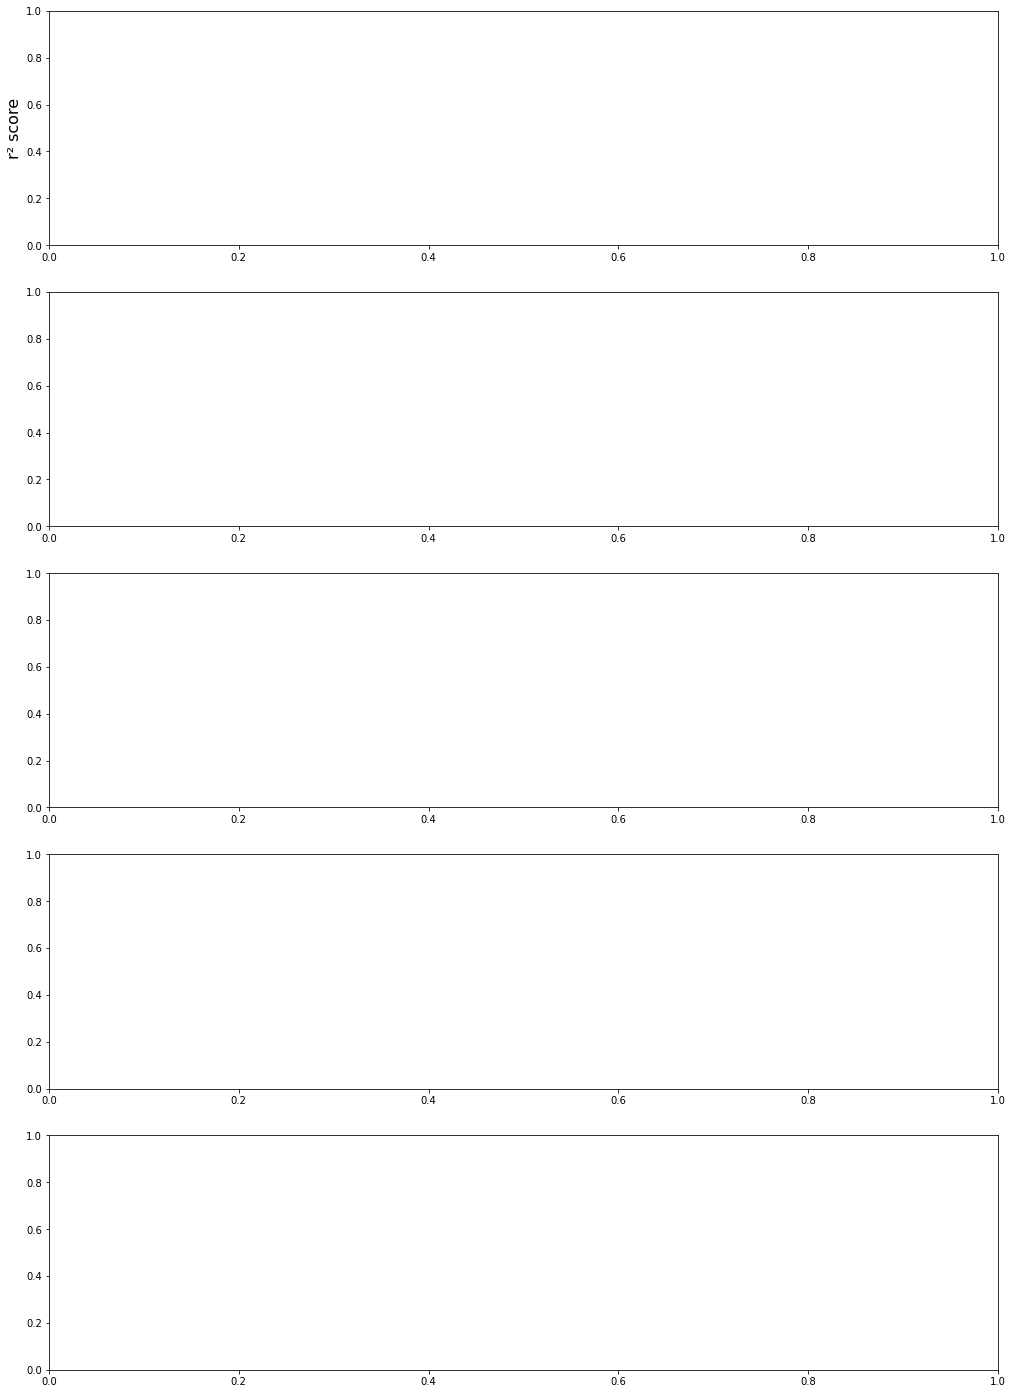

In [10]:
from scipy import stats
selected_conv = 'conv4'

fig, ax = plt.subplots(5, 1, figsize=(17,5*5))
for i, sub in enumerate(['sub-01','sub-02','sub-03','sub-04','sub-06']):
    print(sub)
    for model in os.listdir(results_path):
        if sub in model and '.npy' in model:
            if selected_conv in model:
                conv_path = os.path.join(results_path, model)
            elif '_f_conv' not in model:
                no_ft_path = os.path.join(results_path, model)
                
    conv_data = np.load(conv_path)
    conv_df = pd.DataFrame(conv_data, columns=roi_dataframe['label'])
    no_ft_data = np.load(no_ft_path)
    no_ft_df = pd.DataFrame(no_ft_data, columns=roi_dataframe['label'])
    conv_df = MIST_to_yeo(conv_data, matches)
    no_ft_df = MIST_to_yeo(no_ft_data, matches)
    
    print(no_ft_df.T.shape)
#for i, label in roi_dataframe['label'].iteritems():
#    print(i, label, runs_df[label].shape)

    all_t = list()
    all_p = list()
    for roi in yeo_labels:
        g1 = conv_df[roi]
        g2 = no_ft_df[roi]
        t, p = stats.ttest_rel(g1, g2)
        all_t.append(t)
        all_p.append(p)
    print(all_t, all_p)

    #print(np.count_nonzero(np.array(feature_names)[np.array(all_p) < 0.05]))

    #ax[i].set_title('results from baseline and {} of {}'.format(selected_conv, sub), fontsize=18)
    ax[i].axhline(ls='--', lw=0.5, c='grey')
    ax[i].set_ylabel('r² score', fontsize=16)
    draw_plot(ax[i], no_ft_df.T, -0.2, "tomato", "tomato")
    if i == 4 : 
        draw_plot(ax[i], conv_df.T, +0.2,"skyblue", "skyblue", label = yeo_labels)
        #ax[i].set_xlabel('Regions from the Yeo Parcellation', fontsize=18)
    else : 
        draw_plot(ax[i], conv_df.T, +0.2,"skyblue", "skyblue")

title = 'r2_scores_for_all_runs_of_the_season_42.png'
savepath = os.path.join(results_path, title)
plt.savefig(savepath, bbox_inches='tight')
plt.close()

In [ ]:
ax.set_title('title')
ax.axhline(ls='--', lw=0.5, c='grey')
draw_plot(ax, no_ft_df.T, -0.2, "tomato", "white")
draw_plot(ax, conv_df.T, +0.2,"skyblue", "white", label = yeo_labels)

#plt.savefig(__file__+'.png', bbox_inches='tight')
#plt.show()
#plt.close()

#adapted from https://stackoverflow.com/questions/43612687/python-matplotlib-box-plot-two-data-sets-side-by-side

In [ ]:
mist_7_labels = {
    'cerebellum':['L_CER5', 'R_CER5', 'L_CER9_d', 'R_CER9_d', 'L_CER9_v', 'R_CER9_v', 'L_CER9_m', 'R_CER9_m', 'L_CER7ab', 'R_CER7ab','L_CER6_p','R_CER6_p','L_CER6_d','R_CER6_d','L_CER6_a','R_CER6_a','L_CER7b_m','R_CER7b_m','L_CER7b_l','R_CER7b_l', 'L_N', 'R_N','L_CERCR1','R_CERCR1','L_CERCR2_a','R_CERCR2_a','L_CERCR2_p','R_CERCR2_p'],
    'mesolimbic_network':['L_CAUDNH_NACC', 'R_CAUDNH_NACC', 'L_MORBgyr', 'R_MORBgyr', 'L_LORBgyr', 'R_LORBgyr', 'L_TP', 'R_TP', 'R_ITgyr', 'L_ITgyr', 'R_PINS_v', 'L_PINS_v', 'R_PIsul', 'L_PIsul', 'L_STgyr_a', 'R_STgyr_a', 'L_CERVM', 'R_CERVM', 'R_COLsul', 'L_COLsul', 'L_HIPP', 'R_HIPP', 'R_AMY', 'L_AMY'],
    'somatomotor_network':['L_MOTnet_vl', 'R_MOTnet_vl', 'L_MOTnet_dl', 'R_MOTnet_dl', 'L_MOTnet_l', 'R_MOTnet_l', 'L_MOTnet_am', 'R_MOTnet_am', 'R_MOTnet_m', 'L_MOTnet_m', 'L_MOTnet_ml', 'R_MOTnet_ml'],
    'visual_network':['L_MDVISnet_a', 'R_MDVISnet_a', 'L_MDVISnet_p', 'R_MDVISnet_p', 'L_MVISnet_p', 'R_MVISnet_p', 'L_MVISnet_ad', 'R_MVISnet_ad', 'L_MVISnet_av', 'R_MVISnet_av', 'L_PVISnet_l', 'R_PVISnet_l', 'L_PVISnet_dm', 'R_PVISnet_dm', 'L_PVISnet_vm', 'R_PVISnet_vm', 'R_VVISnet_m', 'L_VVISnet_m', 'R_VVISnet_l', 'L_VVISnet_l', 'R_LVISnet_p', 'L_LVISnet_p', 'R_LVISnet_DP', 'L_LVISnet_DP', 'R_LVISnet_vp', 'L_LVISnet_vp'],
    'default_mode_network':['R_MTgyr_a', 'L_MTgyr_a', 'R_L_MTgyr_a', 'R_ANGgyr', 'L_ANGgyr', 'L_MTgyr_p', 'R_MTgyr_p', 'L_PRC_v', 'R_PRC_v', 'R_PCcor', 'L_PCcor', 'L_PRC_d', 'R_PRC_d', 'L_PRC_d', 'R_PRC_d', 'L_POsul_v', 'R_POsul_v', 'L_POsul_d', 'R_POsul_d', 'L_POsul', 'R_POsul', 'R_PGACcor', 'L_PGACcor', 'L_VMPFcor_p', 'R_VMPFcor_p', 'L_VMPFcor_a', 'R_VMPFcor_a', 'L_IPlob', 'L_IPlob', 'L_DMPFcor_ac', 'L_DMPFcor_ac', 'R_DMPFC_ar', 'L_DMPFC_ar', 'L_SFsul_a', 'R_SFgyr_ad', 'L_SFgyr_ad'],
    'frontoparietal_network':['L_OCCTgyr_l', 'R_OCCTgyr_l', 'R_FUSgyr_vl', 'L_FUSgyr_vl', 'R_FUSgyr_dl', 'L_FUSgyr_dl', 'L_DVIS_v', 'R_DVIS_v', 'R_DVIS_s', 'L_DVIS_s', 'R_DVIS_vl', 'L_DVIS_vl', 'R_SPlob', 'L_SPlob', 'R_SPlob', 'L_SPlob', 'L_IFsul', 'R_IPsul', 'R_PORB', 'R_IFsul', 'R_MFgyr_p', 'L_MFgyr_pr', 'L_MFgyr_pc', 'L_IPsul', 'R_IPlob', 'R_SFsul', 'L_ACcor_d', 'R_ACcor_d', 'L_DMPFcor_p', 'R_DMPFcor_p', 'L_MFgyr_a', 'R_MFgyr_a', 'L_R_FP_l', 'R_VLPFcor', 'L_VLPFcor', 'L_FP', 'R_FP', 'R_L_FP_l'],
    'ventral_attention_network':['L_PUT_a', 'R_PUT_a', 'L_PUT_p', 'R_PUT_p', 'THAL_d', 'R_THAL_d', 'R_THAL_v', 'THAL_v', 'R_CAUDN_v', 'L_CAUDN_v', 'L_CAUDN_d', 'R_CAUDN_d', 'L_CAUDN', 'R_CAUDN', 'R_PINS_d', 'L_PINS_d', 'L_STgyr_m', 'R_STgyr_m', 'R_HSgyr', 'L_HSgyr', 'L_STgyr_p', 'R_STgyr_p', 'L_PCcor', 'R_PCcor', 'R_IMsul', 'L_IMsul', 'R_FEF', 'L_FEF', 'R_CNGsul_p', 'L_CNGsul_p', 'R_PSMcor_p', 'L_PSMcor_p', 'L_PSMcor_a', 'R_PSMcor_a', 'L_AINS_v', 'R_AINS_v', 'L_AINS_pd', 'R_AINS_pd', 'R_AINS_ad', 'L_AINS_ad', 'R_SMgyr', 'L_SMgyr', 'L_R_PCsul','R_l_PCsul', 'L_PCsul_d', 'R_PCsul_d'],
    'auditory_network':['L_STgyr_a', 'R_STgyr_a', 'L_STgyr_m', 'R_STgyr_m', 'L_STgyr_p', 'R_STgyr_p', 'R_HSgyr', 'L_HSgyr']
}